In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

In [2]:
fuel = openmc.Material(name="uo2")
fuel.add_element("U", 1, percent_type="ao", enrichment=4.25)
fuel.add_element("O", 2)
fuel.set_density("g/cc", 10.4)

clad = openmc.Material(name='clad');
clad.add_element("Zr",1);
clad.set_density('g/cc',6.0);

water = openmc.Material(name='water');
water.add_element('O',1);
water.add_element('H',2)
water.set_density('g/cc',0.712); # high temperature density
water.add_s_alpha_beta('c_H_in_H2O');

grph = openmc.Material(name='grph');
grph.add_element('C',0.999999);
grph.add_element('B',0.000001);
grph.set_density('g/cc',1.7);
grph.add_s_alpha_beta('c_Graphite');

materials = openmc.Materials([fuel,clad,water,grph]);

In [3]:
h_core = 300.; 
h_fuel = 200.;

r_fuel = 0.42;
r_pin = 0.45;

P_D = 5.5;

pitch = P_D*2*r_pin;

fuel_temp = 900; # K, guess at fuel temperature
mod_temp = 600; # K, moderator temperature

# fuel cylinder:
fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel, r_fuel);

fuel.volume = np.pi*(r_fuel**2)*h_fuel;

# pin cylinder
pin_cyl = openmc.model.RightCircularCylinder([0.,0.,-(h_fuel+(r_pin-r_fuel))/2.],
                                            h_fuel+(r_pin-r_fuel)*2.,r_pin);

# pin cell container
core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');

fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;
fuel_cell.temperature = fuel_temp;


clad_cell = openmc.Cell();
clad_cell.region = +fuel_cyl & -pin_cyl;
clad_cell.fill = clad;

mod_cell = openmc.Cell();
mod_cell.region = +pin_cyl & -core_cell;
mod_cell.fill = grph

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,clad_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;



materials.export_to_xml();
geometry.export_to_xml();



### Tallies

In [4]:
# get flux energy spectrum in the fuel

# filter for the fuel cell
cell_filter = openmc.CellFilter(fuel_cell)

# set up energy bins
N = 1001
energy_bins = np.logspace(-3,7,num=N)
energy_filter = openmc.EnergyFilter(values=energy_bins)

# establish flux tally
flux = openmc.Tally(name='flux')
flux.scores = ['flux']
flux.filters = [cell_filter,energy_filter]

tallies = openmc.Tallies([flux])

tallies.export_to_xml()




In [5]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 10000;
settings.batches = 100;
settings.inactive = 25

box = openmc.stats.Box(lower_left = (-r_fuel,-r_fuel,-h_fuel/2.),
                      upper_right = (r_fuel,r_fuel,h_fuel/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);

settings.source = src;

#settings.temperature['method']='interpolation';

settings.export_to_xml();

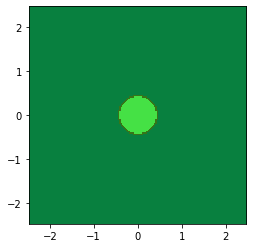

In [6]:
root_univ.plot(width=(pitch,pitch));

In [7]:
openmc.run();

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [8]:
#sp = openmc.StatePoint('statepoint.100.h5')
#sp.tallies

In [9]:
#flux_t = sp.get_tally(name='flux')
#flux_df = flux_t.get_pandas_dataframe()
#flux_vals = flux_df['mean'].to_numpy()

#energy_x = 0.5*(energy_bins[0:-1]+energy_bins[1:])

#plt.loglog(energy_x,flux_vals)
#plt.grid()
#plt.xlabel('Energy [eV]')
#plt.ylabel('flux [n/cm**2-s]')

In [10]:
#operator = openmc.deplete.Operator(geometry,settings,"chain_casl_pwr.xml");
operator = openmc.deplete.Operator(geometry,settings,"chain_endfb71_pwr.xml");


power = 1e4;
days = 24*3600;
time_steps = [0.1*days,0.1*days,0.3*days,0.5*days,1.*days,30.*days,30.*days,100.*days, 360.*days, 360.*days, 360.*days,360.*days,720.*days,720.*days];
integrator = openmc.deplete.PredictorIntegrator(operator,time_steps,power=power);

In [11]:
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mg24 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg24.h5
 Reading Mg25 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg25.h5
 Reading Mg26 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg26.h5
 Reading Al27 from /home/sblair/OMC_DATA/endfb71_hdf5/Al27.h5
 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading P31 from /home/sblair/OMC_DATA/endfb71_hdf5/P31.h5
 Reading S32 from /home/sblair/OMC_DATA/endfb71_hdf5/S32.h5
 Reading S33 from /home/sblair/OMC_DATA/endfb71_hdf5/S33.h5
 Reading S34 from /home/sblair/OMC_DATA/endfb71_hdf5/S34.h5
 Reading S36 from /home/sblair/OMC_DATA/endfb71_hdf5/S36.h5
 Reading Cl35 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl35.h5
 Reading Cl37 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl37.h5
 Reading Ar36 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar36.h5


 Reading Ar38 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar38.h5
 Reading Ar40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar40.h5
 Reading K39 from /home/sblair/OMC_DATA/endfb71_hdf5/K39.h5
 Reading K40 from /home/sblair/OMC_DATA/endfb71_hdf5/K40.h5
 Reading K41 from /home/sblair/OMC_DATA/endfb71_hdf5/K41.h5
 Reading Ca40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca40.h5
 Reading Ca42 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca42.h5
 Reading Ca43 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca43.h5
 Reading Ca44 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca44.h5
 Reading Ca46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca46.h5
 Reading Ca48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca48.h5
 Reading Sc45 from /home/sblair/OMC_DATA/endfb71_hdf5/Sc45.h5
 Reading Ti46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti46.h5
 Reading Ti47 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti47.h5
 Reading Ti48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti48.h5
 Reading Ti49 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti49.h5
 Reading Ti50 

 Reading Se80 from /home/sblair/OMC_DATA/endfb71_hdf5/Se80.h5
 Reading Se82 from /home/sblair/OMC_DATA/endfb71_hdf5/Se82.h5
 Reading Br79 from /home/sblair/OMC_DATA/endfb71_hdf5/Br79.h5
 Reading Br81 from /home/sblair/OMC_DATA/endfb71_hdf5/Br81.h5
 Reading Kr78 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr78.h5
 Reading Kr80 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr80.h5
 Reading Kr82 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr82.h5
 Reading Kr83 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr83.h5
 Reading Kr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr84.h5
 Reading Kr85 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr85.h5
 Reading Kr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr86.h5
 Reading Rb85 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb85.h5
 Reading Rb86 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb86.h5
 Reading Rb87 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb87.h5
 Reading Sr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr84.h5
 Reading Sr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr86.h5
 Reading

 Reading Nb95 from /home/sblair/OMC_DATA/endfb71_hdf5/Nb95.h5
 Reading Mo92 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo92.h5
 Reading Mo94 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo94.h5
 Reading Mo95 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo95.h5
 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5
 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5
 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5


 Reading Ru96 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru96.h5
 Reading Ru98 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru98.h5
 Reading Ru99 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd102 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd102.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd105.h5
 Reading Pd106 from /home/sblair/OMC_DATA/endf

          1200K
          2500K


 Reading Cd110 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd110.h5
 Reading Cd111 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd111.h5
 Reading Cd112 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd112.h5
 Reading Cd113 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd113.h5
 Reading Cd114 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd116.h5
 Reading In113 from /home/sblair/OMC_DATA/endfb71_hdf5/In113.h5
 Reading In115 from /home/sblair/OMC_DATA/endfb71_hdf5/In115.h5
 Reading Sn112 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn112.h5
 Reading Sn113 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn113.h5
 Reading Sn114 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn114.h5
 Reading Sn115 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn115.h5
 Reading Sn116 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn116.h5
 Reading Sn117 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn117.h5
 Reading Sn118 from /home/sblair/O

          1200K
          2500K


 Reading Sn126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn126.h5
 Reading Sb121 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb121.h5
 Reading Sb123 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb123.h5
 Reading Sb124 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb124.h5
 Reading Sb125 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb125.h5
 Reading Sb126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb126.h5
 Reading Te120 from /home/sblair/OMC_DATA/endfb71_hdf5/Te120.h5
 Reading Te122 from /home/sblair/OMC_DATA/endfb71_hdf5/Te122.h5
 Reading Te123 from /home/sblair/OMC_DATA/endfb71_hdf5/Te123.h5
 Reading Te124 from /home/sblair/OMC_DATA/endfb71_hdf5/Te124.h5
 Reading Te125 from /home/sblair/OMC_DATA/endfb71_hdf5/Te125.h5
 Reading Te126 from /home/sblair/OMC_DATA/endfb71_hdf5/Te126.h5


          1200K
          2500K


 Reading Te127_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te127_m1.h5
 Reading Te128 from /home/sblair/OMC_DATA/endfb71_hdf5/Te128.h5
 Reading Te129_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te129_m1.h5
 Reading Te130 from /home/sblair/OMC_DATA/endfb71_hdf5/Te130.h5
 Reading Te132 from /home/sblair/OMC_DATA/endfb71_hdf5/Te132.h5
 Reading I127 from /home/sblair/OMC_DATA/endfb71_hdf5/I127.h5
 Reading I129 from /home/sblair/OMC_DATA/endfb71_hdf5/I129.h5
 Reading I130 from /home/sblair/OMC_DATA/endfb71_hdf5/I130.h5
 Reading I131 from /home/sblair/OMC_DATA/endfb71_hdf5/I131.h5
 Reading I135 from /home/sblair/OMC_DATA/endfb71_hdf5/I135.h5
 Reading Xe123 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe123.h5


 Reading Xe124 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe124.h5
 Reading Xe126 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe126.h5
 Reading Xe128 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe128.h5
 Reading Xe129 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe129.h5
 Reading Xe130 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe130.h5
 Reading Xe131 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe131.h5
 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba130 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba130.h5
 Reading Ba132 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba132.h5
 Reading Ba133 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba133.h5


          1200K
          2500K


 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba135 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba135.h5
 Reading Ba136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba136.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba138.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5
 Reading La138 from /home/sblair/OMC_DATA/endfb71_hdf5/La138.h5
 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce136.h5
 Reading Ce138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce138.h5
 Reading Ce139 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce139.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd153 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd153.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy156 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy156.h5
 Reading Dy158 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy158.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DAT

 Reading Cf246 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf246.h5
 Reading Cf248 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf248.h5
 Reading Cf249 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf249.h5
 Reading Cf250 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf250.h5
 Reading Cf251 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf251.h5
 Reading Cf252 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf252.h5


          1200K


 Reading Cf253 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf253.h5
 Reading Cf254 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf254.h5
 Reading Es251 from /home/sblair/OMC_DATA/endfb71_hdf5/Es251.h5
 Reading Es252 from /home/sblair/OMC_DATA/endfb71_hdf5/Es252.h5
 Reading Es253 from /home/sblair/OMC_DATA/endfb71_hdf5/Es253.h5
 Reading Es254 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254.h5
 Reading Es254_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254_m1.h5
 Reading Es255 from /home/sblair/OMC_DATA/endfb71_hdf5/Es255.h5
 Reading Fm255 from /home/sblair/OMC_DATA/endfb71_hdf5/Fm255.h5
 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.45134
        2/1    1.44020
        3/1    1.45681
        4/1    1.44690
        5/1    1.45882
        6/1    1.43620
        7/1    1.48022
        8/1    1.42936
        9/1    1.50133
       10/1    1.45383
       11/1    1.45996
       12/1    1.47585
       13/1    1.44194
       14/1    1.49134
       15/1    1.46900
       16/1    1.45583
       17/1    1.43236
       18/1    1.44754
       19/1    1.46341
       20/1    1.45592
       21/1    1.46915
       22/1    1.47525
       23/1    1.48124
       24/1    1.48902
       25/1    1.46634
       26/1    1.44678
       27/1    1.46589    1.45633 +/- 0.00956
       28/1    1.46818    1.46028 +/- 0.00678
       29/1    1.46227    1.46078 +/- 0.00482
       30/1    1.45897    1.46042 +/- 0.00375
       31/1    1.43

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.46507
        2/1    1.46486
        3/1    1.46841
        4/1    1.45279
        5/1    1.45217
        6/1    1.46976
        7/1    1.43725
        8/1    1.45926
        9/1    1.45585
       10/1    1.46831
       11/1    1.42467
       12/1    1.46447
       13/1    1.45211
       14/1    1.46686
       15/1    1.45433
       16/1    1.45737
       17/1    1.45925
       18/1    1.50307
       19/1    1.47336
       20/1    1.44604
       21/1    1.48293
       22/1    1.46046
       23/1    1.49130
       24/1    1.45286
       25/1    1.47804
       26/1    1.48105
       27/1    1.44515    1.46310 +/- 0.01795
       28/1    1.46381    1.46334 +/- 0.01037
       29/1    1.49295    1.47074 +/- 0.01042
       30/1    1.47695    1.47198 +/- 0.00816
       31/1    1.45

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.49005
        2/1    1.43527
        3/1    1.42347
        4/1    1.44974
        5/1    1.46436
        6/1    1.50103
        7/1    1.47125
        8/1    1.45891
        9/1    1.43892
       10/1    1.47154
       11/1    1.44440
       12/1    1.46057
       13/1    1.48032
       14/1    1.45354
       15/1    1.44137
       16/1    1.48304
       17/1    1.45175
       18/1    1.45032
       19/1    1.45888
       20/1    1.41668
       21/1    1.49260
       22/1    1.48442
       23/1    1.46714
       24/1    1.46338
       25/1    1.46176
       26/1    1.43576
       27/1    1.45579    1.44578 +/- 0.01002
       28/1    1.46059    1.45071 +/- 0.00760
       29/1    1.43407    1.44655 +/- 0.00680
       30/1    1.47062    1.45136 +/- 0.00713
       31/1    1.43

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.44707
        2/1    1.42625
        3/1    1.45496
        4/1    1.47304
        5/1    1.42759
        6/1    1.44710
        7/1    1.47936
        8/1    1.42195
        9/1    1.43478
       10/1    1.45666
       11/1    1.44915
       12/1    1.43334
       13/1    1.43147
       14/1    1.41815
       15/1    1.44467
       16/1    1.43852
       17/1    1.45455
       18/1    1.44606
       19/1    1.46207
       20/1    1.46093
       21/1    1.46453
       22/1    1.47522
       23/1    1.44134
       24/1    1.45766
       25/1    1.42555
       26/1    1.46521
       27/1    1.44687    1.45604 +/- 0.00917
       28/1    1.46046    1.45751 +/- 0.00550
       29/1    1.44128    1.45345 +/- 0.00562
       30/1    1.45676    1.45412 +/- 0.00440
       31/1    1.46

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.41737
        2/1    1.42814
        3/1    1.48486
        4/1    1.42284
        5/1    1.42066
        6/1    1.46012
        7/1    1.43426
        8/1    1.45793
        9/1    1.43550
       10/1    1.41216
       11/1    1.41909
       12/1    1.43655
       13/1    1.42838
       14/1    1.47626
       15/1    1.43378
       16/1    1.45877
       17/1    1.43140
       18/1    1.46128
       19/1    1.45899
       20/1    1.43213
       21/1    1.42521
       22/1    1.44453
       23/1    1.44289
       24/1    1.45448
       25/1    1.45905
       26/1    1.46847
       27/1    1.43445    1.45146 +/- 0.01701
       28/1    1.43168    1.44487 +/- 0.01183
       29/1    1.43621    1.44270 +/- 0.00864
       30/1    1.44070    1.44230 +/- 0.00670
       31/1    1.42

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.41088
        2/1    1.41738
        3/1    1.45526
        4/1    1.43527
        5/1    1.43124
        6/1    1.40914
        7/1    1.41112
        8/1    1.42220
        9/1    1.43963
       10/1    1.43078
       11/1    1.42120
       12/1    1.40873
       13/1    1.39495
       14/1    1.40869
       15/1    1.43892
       16/1    1.39716
       17/1    1.45572
       18/1    1.40816
       19/1    1.42882
       20/1    1.44904
       21/1    1.42858
       22/1    1.42932
       23/1    1.44111
       24/1    1.41143
       25/1    1.45138
       26/1    1.44863
       27/1    1.45434    1.45149 +/- 0.00286
       28/1    1.44540    1.44946 +/- 0.00262
       29/1    1.44724    1.44890 +/- 0.00193
       30/1    1.44089    1.44730 +/- 0.00219
       31/1    1.43

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.43377
        2/1    1.42604
        3/1    1.41778
        4/1    1.40847
        5/1    1.42834
        6/1    1.42001
        7/1    1.37334
        8/1    1.38656
        9/1    1.41815
       10/1    1.41023
       11/1    1.39680
       12/1    1.42524
       13/1    1.42058
       14/1    1.40433
       15/1    1.39689
       16/1    1.44051
       17/1    1.40009
       18/1    1.42372
       19/1    1.46424
       20/1    1.44409
       21/1    1.39423
       22/1    1.43091
       23/1    1.39813
       24/1    1.40656
       25/1    1.42260
       26/1    1.39286
       27/1    1.45843    1.42564 +/- 0.03279
       28/1    1.43561    1.42897 +/- 0.01922
       29/1    1.42517    1.42802 +/- 0.01362
       30/1    1.43153    1.42872 +/- 0.01058
       31/1    1.43

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.42669
        2/1    1.40248
        3/1    1.41289
        4/1    1.40757
        5/1    1.41089
        6/1    1.40861
        7/1    1.40897
        8/1    1.42312
        9/1    1.40339
       10/1    1.40723
       11/1    1.40727
       12/1    1.40951
       13/1    1.42985
       14/1    1.40289
       15/1    1.41300
       16/1    1.39372
       17/1    1.41034
       18/1    1.41401
       19/1    1.38448
       20/1    1.41881
       21/1    1.40996
       22/1    1.42671
       23/1    1.42743
       24/1    1.40925
       25/1    1.42259
       26/1    1.39365
       27/1    1.41098    1.40231 +/- 0.00867
       28/1    1.42200    1.40888 +/- 0.00825
       29/1    1.43399    1.41515 +/- 0.00857
       30/1    1.42260    1.41664 +/- 0.00681
       31/1    1.43

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.41108
        2/1    1.42848
        3/1    1.43281
        4/1    1.40322
        5/1    1.38264
        6/1    1.40385
        7/1    1.40371
        8/1    1.38504
        9/1    1.40818
       10/1    1.38427
       11/1    1.42040
       12/1    1.41426
       13/1    1.39463
       14/1    1.38467
       15/1    1.41886
       16/1    1.37759
       17/1    1.39780
       18/1    1.41985
       19/1    1.40681
       20/1    1.42103
       21/1    1.44179
       22/1    1.42739
       23/1    1.41421
       24/1    1.37543
       25/1    1.42345
       26/1    1.40754
       27/1    1.39761    1.40258 +/- 0.00496
       28/1    1.42337    1.40951 +/- 0.00750
       29/1    1.38469    1.40330 +/- 0.00816
       30/1    1.40938    1.40452 +/- 0.00644
       31/1    1.39

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.34174
        2/1    1.39885
        3/1    1.35817
        4/1    1.37307
        5/1    1.35567
        6/1    1.40321
        7/1    1.35406
        8/1    1.34978
        9/1    1.34131
       10/1    1.37108
       11/1    1.36135
       12/1    1.35897
       13/1    1.38008
       14/1    1.38406
       15/1    1.38842
       16/1    1.37642
       17/1    1.37086
       18/1    1.34951
       19/1    1.38624
       20/1    1.34847
       21/1    1.38588
       22/1    1.36923
       23/1    1.36883
       24/1    1.38907
       25/1    1.37561
       26/1    1.38519
       27/1    1.37856    1.38187 +/- 0.00331
       28/1    1.38684    1.38353 +/- 0.00253
       29/1    1.38505    1.38391 +/- 0.00183
       30/1    1.34047    1.37522 +/- 0.00880
       31/1    1.37

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.33797
        2/1    1.32461
        3/1    1.32574
        4/1    1.33256
        5/1    1.30726
        6/1    1.32385
        7/1    1.30829
        8/1    1.32503
        9/1    1.31474
       10/1    1.32164
       11/1    1.32735
       12/1    1.32955
       13/1    1.30371
       14/1    1.31991
       15/1    1.30745
       16/1    1.34552
       17/1    1.31508
       18/1    1.34560
       19/1    1.34349
       20/1    1.32605
       21/1    1.33990
       22/1    1.31312
       23/1    1.33871
       24/1    1.32227
       25/1    1.33948
       26/1    1.34065
       27/1    1.32099    1.33082 +/- 0.00983
       28/1    1.34030    1.33398 +/- 0.00649
       29/1    1.34301    1.33624 +/- 0.00512
       30/1    1.32571    1.33413 +/- 0.00449
       31/1    1.33

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.29090
        2/1    1.28539
        3/1    1.26566
        4/1    1.26740
        5/1    1.28655
        6/1    1.29387
        7/1    1.27814
        8/1    1.28209
        9/1    1.29020
       10/1    1.29806
       11/1    1.27514
       12/1    1.29712
       13/1    1.28529
       14/1    1.28937
       15/1    1.27838
       16/1    1.26665
       17/1    1.28826
       18/1    1.27608
       19/1    1.28248
       20/1    1.27925
       21/1    1.29691
       22/1    1.26783
       23/1    1.27089
       24/1    1.29988
       25/1    1.31034
       26/1    1.25832
       27/1    1.28756    1.27294 +/- 0.01462
       28/1    1.28200    1.27596 +/- 0.00896
       29/1    1.29577    1.28091 +/- 0.00804
       30/1    1.28997    1.28272 +/- 0.00649
       31/1    1.27

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.24580
        2/1    1.27530
        3/1    1.22704
        4/1    1.25991
        5/1    1.24462
        6/1    1.25563
        7/1    1.24863
        8/1    1.23933
        9/1    1.24977
       10/1    1.25285
       11/1    1.23285
       12/1    1.25225
       13/1    1.27042
       14/1    1.24534
       15/1    1.23922
       16/1    1.24898
       17/1    1.27125
       18/1    1.25197
       19/1    1.25240
       20/1    1.23612
       21/1    1.25119
       22/1    1.22481
       23/1    1.26516
       24/1    1.22316
       25/1    1.26694
       26/1    1.22298
       27/1    1.22822    1.22560 +/- 0.00262
       28/1    1.23910    1.23010 +/- 0.00475
       29/1    1.22895    1.22981 +/- 0.00337
       30/1    1.20599    1.22505 +/- 0.00543
       31/1    1.24

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.16856
        2/1    1.15746
        3/1    1.18102
        4/1    1.19696
        5/1    1.18493
        6/1    1.17081
        7/1    1.17974
        8/1    1.16238
        9/1    1.16906
       10/1    1.17696
       11/1    1.15738
       12/1    1.15955
       13/1    1.14437
       14/1    1.19666
       15/1    1.19925
       16/1    1.16002
       17/1    1.19320
       18/1    1.17249
       19/1    1.14606
       20/1    1.19894
       21/1    1.18299
       22/1    1.17640
       23/1    1.17401
       24/1    1.17869
       25/1    1.15611
       26/1    1.17702
       27/1    1.15822    1.16762 +/- 0.00940
       28/1    1.16562    1.16696 +/- 0.00547
       29/1    1.15707    1.16449 +/- 0.00459
       30/1    1.18023    1.16763 +/- 0.00475
       31/1    1.17

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.07294
        2/1    1.10995
        3/1    1.09396
        4/1    1.07328
        5/1    1.10146
        6/1    1.09612
        7/1    1.09015
        8/1    1.08031
        9/1    1.10616
       10/1    1.10227
       11/1    1.10164
       12/1    1.10333
       13/1    1.09105
       14/1    1.08386
       15/1    1.10731
       16/1    1.10621
       17/1    1.09739
       18/1    1.09492
       19/1    1.09248
       20/1    1.09935
       21/1    1.12047
       22/1    1.06909
       23/1    1.08696
       24/1    1.08080
       25/1    1.13101
       26/1    1.09978
       27/1    1.08473    1.09225 +/- 0.00753
       28/1    1.11221    1.09891 +/- 0.00795
       29/1    1.10401    1.10018 +/- 0.00576
       30/1    1.10956    1.10206 +/- 0.00484
       31/1    1.13

In [12]:
results = openmc.deplete.ResultsList.from_hdf5('./depletion_results.h5')

In [13]:
time,k = results.get_eigenvalue()
time /= (24*60*60);

In [14]:
from matplotlib import pyplot

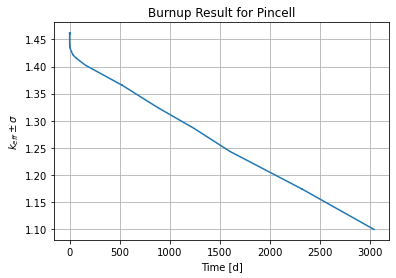

In [15]:
pyplot.errorbar(time,k[:,0],yerr=k[:,1]);
pyplot.title('Burnup Result for Pincell')
pyplot.xlabel('Time [d]');
pyplot.ylabel('$k_{eff} \pm \sigma$');
pyplot.grid()

In [16]:
chain = openmc.deplete.Chain.from_xml("chain_endfb71_pwr.xml")

In [17]:
chain.nuclide_dict

OrderedDict([('H1', 0),
             ('H2', 1),
             ('H3', 2),
             ('H4', 3),
             ('H5', 4),
             ('H6', 5),
             ('H7', 6),
             ('He3', 7),
             ('He4', 8),
             ('He5', 9),
             ('He6', 10),
             ('He7', 11),
             ('He8', 12),
             ('He9', 13),
             ('He10', 14),
             ('Li4', 15),
             ('Li5', 16),
             ('Li6', 17),
             ('Li7', 18),
             ('Li8', 19),
             ('Li9', 20),
             ('Li10', 21),
             ('Li11', 22),
             ('Li12', 23),
             ('Be5', 24),
             ('Be6', 25),
             ('Be7', 26),
             ('Be8', 27),
             ('Be9', 28),
             ('Be10', 29),
             ('Be11', 30),
             ('Be12', 31),
             ('Be13', 32),
             ('Be14', 33),
             ('Be15', 34),
             ('Be16', 35),
             ('B6', 36),
             ('B7', 37),
             ('B8', 

In [18]:
time, xe135 = results.get_atoms("1","Xe135")

Text(0, 0.5, 'Number of atoms - Xe135')

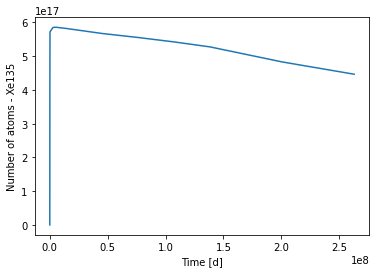

In [19]:
pyplot.plot(time,xe135,label="Xe135")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Xe135")

In [20]:
time, cs137 = results.get_atoms("1","Cs137")

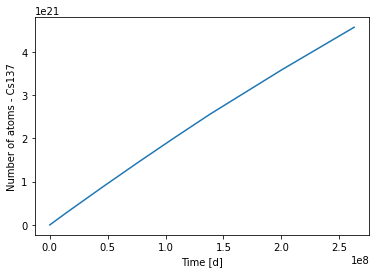

In [21]:
pyplot.plot(time,cs137,label="Cs137");
pyplot.xlabel("Time [d]");
pyplot.ylabel("Number of atoms - Cs137");